In [1]:
import os
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
import PIL.ImageOps
import cv2
import keras
import keras.backend as K
from IPython.display import *

/home/marco/.virtualenvs/ml/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def load_dataset(path):
    imgs = []
    d = 'downloads/{}/'.format(path)
    for f in os.listdir(d):
        try:
            img = PIL.Image.open(d+f)
        except:
            continue
        img = PIL.ImageOps.fit(img, (128, 128), PIL.Image.ANTIALIAS, 0, (0.5, 0.5))
        img = np.asarray(img)
        if img.shape != (128,128,3):
            continue
        imgs.append(img)
    return np.array(imgs) / 255.
birds = load_dataset('colourful birds')
cockatiel = load_dataset('colourful cockatiel')
owl = load_dataset('colourful owl')
parrot = load_dataset('colourful parrot')
pigeon = load_dataset('colourful pigeon')
sparrow = load_dataset('colourful sparrow')
birds.shape, cockatiel.shape, owl.shape, parrot.shape, pigeon.shape, sparrow.shape

#apple = load_dataset('apple fruit')
#orange = load_dataset('orange fruit')

((97, 128, 128, 3),
 (100, 128, 128, 3),
 (99, 128, 128, 3),
 (99, 128, 128, 3),
 (100, 128, 128, 3),
 (98, 128, 128, 3))

In [3]:
colored = np.vstack([birds, cockatiel, owl, parrot, pigeon, sparrow])
#colored = np.vstack([apple, orange])
shuffle_order = list(range(len(colored)))
random.shuffle(shuffle_order)
colored = colored[shuffle_order]
train_colored = colored[:colored.shape[0]//2]
test_colored = colored[colored.shape[0]//2:]
nocolor = np.zeros_like(colored)
#nocolor[:,:,:,2] = nocolor[:,:,:,1] = nocolor[:,:,:,0] = 0.2126*colored[:,:,:,0] + 0.7152*colored[:,:,:,1] + 0.0722*colored[:,:,:,2]
for i in range(colored.shape[0]):
    nocolor[i,:,:,0] = \
    nocolor[i,:,:,1] = \
    nocolor[i,:,:,2] = \
    1-cv2.Canny(np.uint8(colored[i]*255), 150, 300)/255
train_nocolor = nocolor[:nocolor.shape[0]//2]
test_nocolor = nocolor[nocolor.shape[0]//2:]

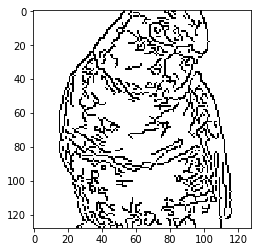

In [4]:
plt.imshow(train_nocolor[45])
plt.show()

In [5]:
K.clear_session()

M_dis_clip = lambda w: K.clip(w, -0.01, 0.01)

L = L0 = keras.layers.Input((128,128,3))
L = keras.layers.Conv2D(32, (3,3), padding='same', kernel_constraint=M_dis_clip)(L)
L = keras.layers.BatchNormalization()(L)
L = keras.layers.LeakyReLU()(L)
L = keras.layers.AveragePooling2D()(L)
L = keras.layers.Conv2D(64, (3,3), padding='same', kernel_constraint=M_dis_clip)(L)
L = keras.layers.BatchNormalization()(L)
L = keras.layers.LeakyReLU()(L)
L = keras.layers.AveragePooling2D()(L)
L = keras.layers.Conv2D(128, (3,3), padding='same', kernel_constraint=M_dis_clip)(L)
L = keras.layers.BatchNormalization()(L)
L = keras.layers.LeakyReLU()(L)
L = keras.layers.AveragePooling2D()(L)
L = keras.layers.Conv2D(256, (3,3), padding='same', kernel_constraint=M_dis_clip)(L)
L = keras.layers.BatchNormalization()(L)
L = keras.layers.LeakyReLU()(L)
L = keras.layers.Conv2D(1, (1,1), padding='same', kernel_constraint=M_dis_clip)(L)
#L = keras.layers.AveragePooling2D()(L)
#L = keras.layers.Conv2D(64, (3,3), padding='same', kernel_constraint=M_dis_clip)(L)
#L = keras.layers.BatchNormalization()(L)
#L = keras.layers.LeakyReLU()(L)
#L = keras.layers.AveragePooling2D()(L)
#L = keras.layers.Flatten()(L)
#L = keras.layers.Dense(1, kernel_constraint=M_dis_clip)(L)
L = keras.layers.Lambda(lambda x: K.reshape(K.mean(x, axis=(1,2,3), keepdims=False), [K.shape(x)[0],1]))(L)
M_dis = keras.models.Model([L0], [L])
M_dis.compile('rmsprop', 'binary_crossentropy')
M_dis.summary()
M_dis_freeze = keras.models.Model([L0], [L])
M_dis_freeze.trainable = False
M_dis_freeze.compile('rmsprop', 'binary_crossentropy')

L = L0 = keras.layers.Input((128,128,3))
L_rand = L0_rand = keras.layers.Input((128,))
L = keras.layers.Conv2D(64, (3,3), padding='same')(L)
L = keras.layers.BatchNormalization()(L)
L = keras.layers.LeakyReLU()(L)
L = L_skip1 = keras.layers.AveragePooling2D()(L)
L = keras.layers.Conv2D(64, (3,3), padding='same')(L)
L = keras.layers.BatchNormalization()(L)
L = keras.layers.LeakyReLU()(L)
L = L_skip2 = keras.layers.AveragePooling2D()(L)
L = keras.layers.Conv2D(64, (3,3), padding='same')(L)
L = keras.layers.BatchNormalization()(L)
L = keras.layers.LeakyReLU()(L)
L = L_skip3 = keras.layers.AveragePooling2D()(L)
L = keras.layers.Conv2D(128, (3,3), padding='same')(L)
L = keras.layers.BatchNormalization()(L)
L = keras.layers.LeakyReLU()(L)
L = L_skip4 = keras.layers.AveragePooling2D()(L)
L = keras.layers.Conv2D(128, (3,3), padding='same')(L)
L = keras.layers.BatchNormalization()(L)
L = keras.layers.LeakyReLU()(L)
L = L_skip5 = keras.layers.AveragePooling2D()(L)
L = keras.layers.Flatten()(L)
L_u = keras.layers.Dense(128)(L)
L_u = keras.layers.BatchNormalization()(L_u)
L_u = keras.layers.LeakyReLU()(L_u)
L_ls = keras.layers.Dense(128)(L)
L_ls = keras.layers.BatchNormalization()(L_ls)
L_ls = keras.layers.LeakyReLU()(L_ls)
L = keras.layers.Lambda(lambda x: x[0] + K.exp(x[1])*x[2])([L_u, L_ls, L_rand])
L = keras.layers.Dense(128*4*4)(L)
L = keras.layers.Reshape((4,4,128))(L)
L = keras.layers.BatchNormalization()(L)
L = keras.layers.LeakyReLU()(L)
L = keras.layers.Concatenate()([L, L_skip5])
L = keras.layers.Conv2D(128*4, (3,3), padding='same')(L)
L = keras.layers.Reshape((4,4,2,2,128))(L)
L = keras.layers.Permute((1,3,2,4,5))(L)
L = keras.layers.Reshape((8,8,128))(L)
L = keras.layers.BatchNormalization()(L)
L = keras.layers.LeakyReLU()(L)
L = keras.layers.Concatenate()([L, L_skip4])
L = keras.layers.Conv2D(64*4, (3,3), padding='same')(L)
L = keras.layers.Reshape((8,8,2,2,64))(L)
L = keras.layers.Permute((1,3,2,4,5))(L)
L = keras.layers.Reshape((16,16,64))(L)
L = keras.layers.BatchNormalization()(L)
L = keras.layers.LeakyReLU()(L)
L = keras.layers.Concatenate()([L, L_skip3])
L = keras.layers.Conv2D(64*4, (3,3), padding='same')(L)
L = keras.layers.Reshape((16,16,2,2,64))(L)
L = keras.layers.Permute((1,3,2,4,5))(L)
L = keras.layers.Reshape((32,32,64))(L)
L = keras.layers.BatchNormalization()(L)
L = keras.layers.LeakyReLU()(L)
L = keras.layers.Concatenate()([L, L_skip2])
L = keras.layers.Conv2D(64*4, (3,3), padding='same')(L)
L = keras.layers.Reshape((32,32,2,2,64))(L)
L = keras.layers.Permute((1,3,2,4,5))(L)
L = keras.layers.Reshape((64,64,64))(L)
L = keras.layers.BatchNormalization()(L)
L = keras.layers.LeakyReLU()(L)
L = keras.layers.Concatenate()([L, L_skip1])
L = keras.layers.Conv2D(3*4, (3,3), padding='same', activation='sigmoid')(L)
L = keras.layers.Reshape((64,64,2,2,3))(L)
L = keras.layers.Permute((1,3,2,4,5))(L)
L = keras.layers.Reshape((128,128,3))(L)
M_gen = keras.models.Model([L0, L0_rand], [L])
M_gen.compile('rmsprop', 'mse')
M_gen.summary()
M_gen_freeze = keras.models.Model([L0, L0_rand], [L])
M_gen_freeze.trainable = False
M_gen_freeze.compile('rmsprop', 'mse')

M_loss_gan = lambda l,y: -K.mean((l*2.-1.)*y)

L_R = L0_R = keras.layers.Input((128,128,3))
L_R = M_dis(L_R)
L_F = L0_F = keras.layers.Input((128,128,3))
L_F_rand = L0_F_rand = keras.layers.Input((128,))
L_F = M_gen_freeze([L_F, L_F_rand])
L_F = M_dis(L_F)
M_dis_train_opt = keras.optimizers.RMSprop(lr=0.00005)
M_dis_train = keras.models.Model([L0_R, L0_F, L0_F_rand], [L_R, L_F])
M_dis_train.compile(M_dis_train_opt, M_loss_gan)

L_F = L0_F = keras.layers.Input((128,128,3))
L_F_rand = L0_F_rand = keras.layers.Input((128,))
L_F = L_G = M_gen([L_F, L_F_rand])
L_F = M_dis_freeze(L_F)
M_gen_train_opt = keras.optimizers.RMSprop(lr=0.00005)
M_gen_train = keras.models.Model([L0_F, L0_F_rand], [L_F, L_G])
M_gen_train.compile(M_gen_train_opt, [M_loss_gan, keras.losses.mae], loss_weights=[1., 5.])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 32)      0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 64)        256       
__________

Epoch 55/55
64/64 [==============================] - 0s 7ms/step - loss: -0.3441 - model_1_loss: -0.1411
Epoch 55/55
64/64 [==============================] - 0s 7ms/step - loss: -0.3234 - model_1_loss: -0.1308
Epoch 55/55
64/64 [==============================] - 0s 7ms/step - loss: -0.3751 - model_1_loss: -0.1646
Epoch 55/55
64/64 [==============================] - 0s 7ms/step - loss: -0.3232 - model_1_loss: -0.1468
Epoch 55/55
64/64 [==============================] - 0s 7ms/step - loss: -0.3810 - model_1_loss: -0.1486
Epoch 55/55
64/64 [==============================] - 0s 8ms/step - loss: 1.3672 - model_2_loss: 0.1483 - model_3_loss: 0.2438


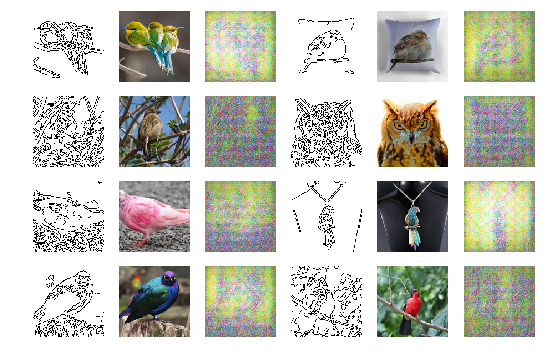

In [ ]:
%%time
for epoch in range(20000):
    
    verbose = (epoch+1) % 5 == 0
    if verbose:
        clear_output()
    
    for _ in range(5):
        real_sample = train_colored[np.random.randint(0, train_colored.shape[0], size=64),:,:,:]
        fake_sample = train_nocolor[np.random.randint(0, train_nocolor.shape[0], size=64),:,:,:]
        fake_rand = np.random.randn(fake_sample.shape[0], 128)
        real_label = np.ones((real_sample.shape[0],1))
        fake_label = np.zeros((real_sample.shape[0],1))
        M_dis_train.fit([real_sample, fake_sample, fake_rand], [real_label, fake_label], epochs=epoch+1, initial_epoch=epoch, verbose=verbose)
    sample_idx = np.random.randint(0, train_colored.shape[0], size=64)
    real_sample = train_colored[sample_idx,:,:,:]
    fake_sample = train_nocolor[sample_idx,:,:,:]
    fake_rand = np.random.randn(fake_sample.shape[0], 128)
    M_gen_train.fit([fake_sample, fake_rand], [real_label, real_sample], epochs=epoch+1, initial_epoch=epoch, verbose=verbose)
    
    if verbose:
        test_sample_idx = np.random.randint(0, test_nocolor.shape[0], size=4)
        train_sample_idx = np.random.randint(0, train_nocolor.shape[0], size=4)
        fake_sample = np.vstack((
            test_nocolor[test_sample_idx,:,:,:],
            train_nocolor[train_sample_idx,:,:,:]))
        fake_sample_target = np.vstack((
            test_colored[test_sample_idx,:,:,:],
            train_colored[train_sample_idx,:,:,:]))
        fake_rand = np.random.randn(8, 128)
        generated = M_gen.predict([fake_sample, fake_rand])
        plt.figure(figsize=(9,6))
        for i in range(8):
            plt.subplot(4, 6, (i*3)+1)
            plt.axis('off')
            plt.imshow(fake_sample[i])
            plt.subplot(4, 6, (i*3)+2)
            plt.axis('off')
            plt.imshow(fake_sample_target[i])
            plt.subplot(4, 6, (i*3)+3)
            plt.axis('off')
            plt.imshow(generated[i])
        plt.show()
    
    if (epoch+1) % 500 == 0:
        time.sleep(30)

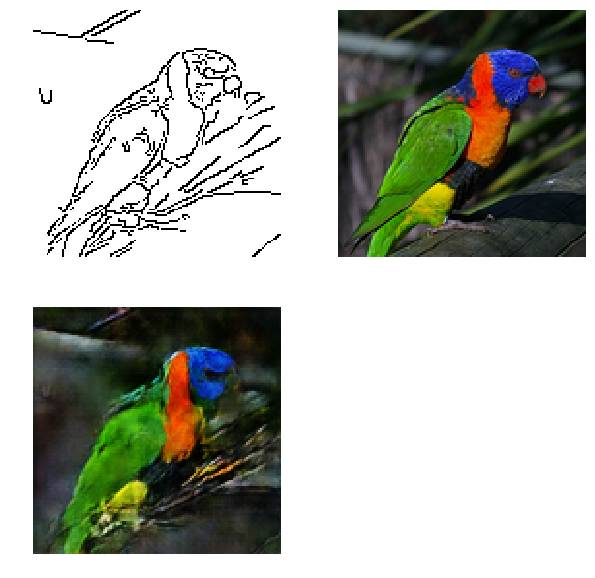

In [543]:
sample_idx = np.random.randint(0, test_nocolor.shape[0])
sample = train_nocolor[np.newaxis, sample_idx]
target = train_colored[np.newaxis, sample_idx]
fake_rand = np.random.randn(sample.shape[0], 128)
generated = M_gen.predict([sample, fake_rand])[0]
plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
plt.axis('off')
plt.imshow(sample[0])
plt.subplot(2, 2, 2)
plt.axis('off')
plt.imshow(target[0])
plt.subplot(2, 2, 3)
plt.axis('off')
plt.imshow(generated)
plt.show()